In [1]:
import os
import matplotlib.pyplot as plt
import sys
import csv

#Replace this path with wherever you saved the PPG Tools folder
sys.path.insert(0, r'ppgtools')

import numpy as np
from scipy import signal
from ppgtools.sigimport import importBIN, importEventMarkers, EventMarker
from ppgtools.biosignal import BioSignal

from ppgtools import sigpro, sigimport, sigplot, biometrics

import scipy.stats as stats
import copy
from sklearn.decomposition import FastICA

In [42]:
#%%
path = r"Data" #Put the directory you have the data in
filename = r"\double" #Outer folder name of dataset (e.g., artery, vein, double)
devicename = "PPG Tattoo v3.2_DC.2B.5A.AE.9E.29"   #Don't change this

In [43]:
#Load in data
sessionData = sigimport.importTattooData(path, filename)

signals_original = sessionData[devicename]["Data"]
markers = sessionData[devicename]["Markers"]     

['PPG Tattoo v3.2_DC.2B.5A.AE.9E.29']
File 'Data/\double/PPG Tattoo v3.2_DC.2B.5A.AE.9E.29/\double_PPG Tattoo v3.2_DC.2B.5A.AE.9E.29.tat' size: 454.617 kB
TAT file version: 1

Reading file header (size: 288 bytes) for signal information

Index: 0
Name: IR Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 1
Name: Red Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 2
Name: Green Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 3
Name: Ambient (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 4
Name: IR Signal (D)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 5
Name: Red Signal (D)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 6
Name: Green Signal (D)
Bytes per point: 3


In [14]:
len(signals_original[0].data)//50

302

In [12]:
signals_original[3].data.mean()

2097472.86494406

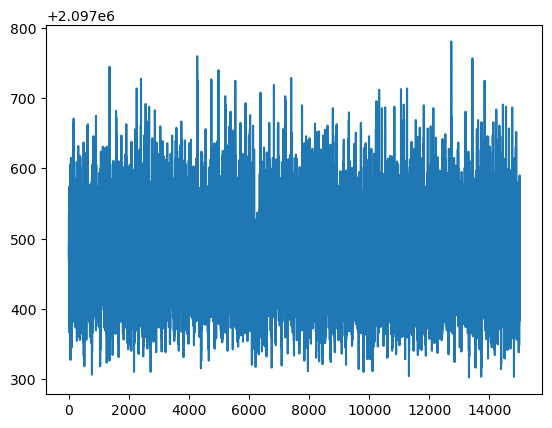

In [38]:
plt.plot(signals_original[3].data)

In [41]:
len(signals_original[4].data)//50

300

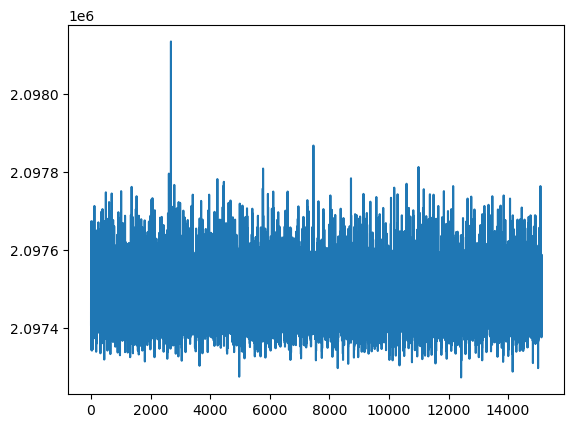

In [28]:
plt.plot(signals_original[3].data)

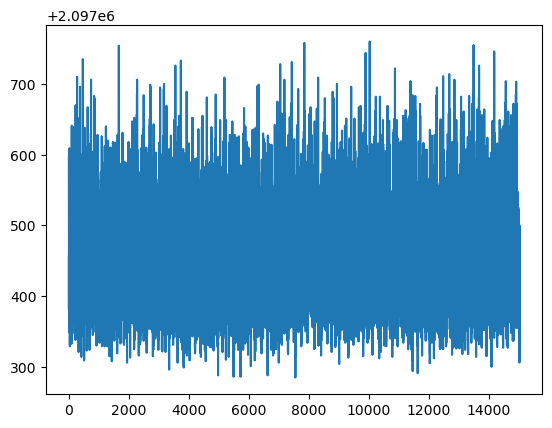

In [25]:
plt.plot(signals_original[3].data)

In [45]:
signals_original[5].data

array([4718663, 4718615, 4718905, ..., 4718836, 4718592, 4718592])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


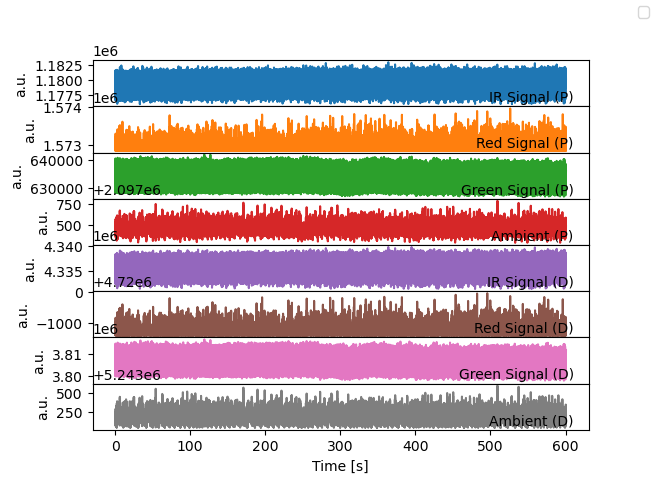

In [44]:
sigplot.plot_biosignals(signals_original[0:8])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


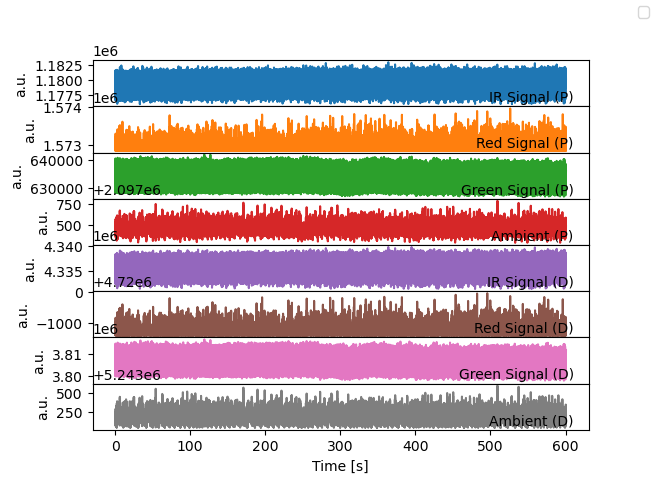

In [14]:
sigplot.plot_biosignals(signals_original[0:8])

In [ ]:
signals_original[7].data.mean()

In [82]:
{i:signal.name for i,signal in enumerate(signals_original)}

{0: 'IR Signal (P)',
 1: 'Red Signal (P)',
 2: 'Green Signal (P)',
 3: 'Ambient (P)',
 4: 'IR Signal (D)',
 5: 'Red Signal (D)',
 6: 'Green Signal (D)',
 7: 'Ambient (D)',
 8: 'Acceleration (X)',
 9: 'Acceleration (Y)',
 10: 'Acceleration (Z)',
 11: 'Temperature'}

In [26]:
len(signals_original[0].data)

15136

In [34]:
t = np.linspace(0, len(signals_original[0].data) / signals_original[0].fs, len(signals_original[0].data))

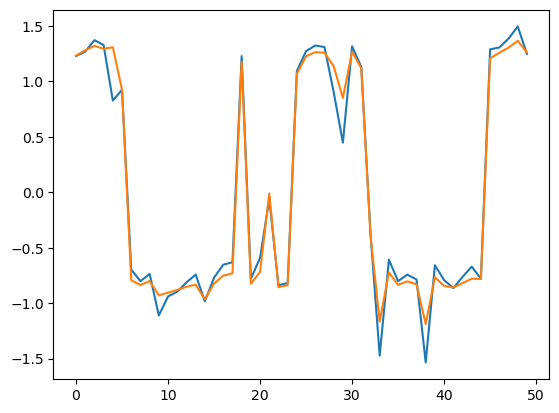

In [81]:
i = 10
sig1 = signals_original[6].data[i*25:i*25+50]
sig2 = signals_original[2].data[i*25:i*25+50]
plt.plot((sig1-sig1.mean())/sig1.std())
plt.plot((sig2-sig2.mean())/sig2.std())

In [4]:
signals_original[0].data

array([1179708, 1179837, 1179849, ..., 1178680, 1178174, 1179379])

In [6]:
signals_original[1].data

array([1572864, 1572888, 1572895, ..., 1572893, 1572864, 1572864])

In [7]:
signals_original[2].data

array([638036, 638131, 638150, ..., 635713, 635212, 638582])

In [22]:
min(signals_original[3].data - int(signals_original[3].data.mean()))

-211

In [3]:
import torch

c:\Users\geffen\miniconda3\envs\dv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import numpy as np

In [11]:
dataset = torch.arange(100)
train_frac = 0.8
val_frac = 0.1

num_train_total = int(train_frac*len(dataset)) # train-test split
num_test = len(dataset) - num_train_total
num_val = int(val_frac*num_train_total) # train-val split
num_train = num_train_total - num_val

# since this is time series data, let's split into disjoint blocks
# select a contiguous block for testing, then one for validation, and use the remaining samples for training
# add padding between blocks to prevent overlap
# -----------------------------------------------------
# |   train   || test || train || validation || train |
# -----------------------------------------------------

padding = 2 # leave two windows unused between each block

# get random test block
test_start = torch.randperm(len(dataset))[0]
test_end = test_start + num_test
if test_end > len(dataset): # if extends beyond end, shift accordingly
    test_start = len(dataset) - num_test
    test_end = len(dataset)

# get random validation block
val_start = torch.randperm(len(dataset))[0]
val_end = val_start + num_val
if val_end > len(dataset): # if extends beyond end, shift accordingly
    val_start = len(dataset) - num_val
    val_end = len(dataset)
if val_end > test_start and val_end < test_end: # if right side overlaps with test, shift accordingly
    val_start = test_start - num_val - padding
    val_end = test_start - padding
    if val_start < 0: # if shift beyond start, move to other side of test block
        val_start = test_end + padding
        val_end = val_start + num_val
elif val_start > test_start and val_start < test_end: # if left side overlaps with test, shift accordingly
    val_start = test_end + padding
    val_end = val_start + num_val
    if val_end > len(dataset): # if shift beyond end, move to other side of test block
        val_start = test_start - num_val - padding
        val_end = test_start - padding

# use remaining indices for training
test_indices = torch.arange(test_start,test_end)
val_indices = torch.arange(val_start,val_end)

all_indices = torch.arange(len(dataset))
train_indices = torch.from_numpy(np.setdiff1d(all_indices.numpy(),torch.cat([test_indices,val_indices]).numpy()))

In [12]:
print(test_indices)
print(val_indices)
print(train_indices)

tensor([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
        98, 99])
tensor([70, 71, 72, 73, 74, 75, 76, 77])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 78, 79])


In [15]:
import datetime
import logging 
import time
import sys
import torch
import numpy as np
import random
import os

In [27]:
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[
            logging.FileHandler("saved_data\\logs\\test.log"),
            logging.StreamHandler(sys.stdout)
        ]
    )
logger=logging.getLogger() 
logger.setLevel(logging.INFO)

In [1]:
from datasets import *

c:\Users\geffen\miniconda3\envs\dv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tr,te = load_ppg_dataset(16,50,0,0.8,0.1,1234,[-1,1],False)

['PPG Tattoo v3.2_DC.2B.5A.AE.9E.29']
File 'Data/\artery/PPG Tattoo v3.2_DC.2B.5A.AE.9E.29/\artery_PPG Tattoo v3.2_DC.2B.5A.AE.9E.29.tat' size: 458.247 kB
TAT file version: 1

Reading file header (size: 288 bytes) for signal information

Index: 0
Name: IR Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 1
Name: Red Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 2
Name: Green Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 3
Name: Ambient (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 4
Name: IR Signal (D)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 5
Name: Red Signal (D)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 6
Name: Green Signal (D)
Bytes per point: 3


In [6]:
signal_data = signals_original[0].data
rescale = [-1,1]
signal_data = ((signal_data-min(signal_data))/(max(signal_data)-min(signal_data)))*(rescale[1]-rescale[0]) + rescale[0]

In [7]:
start = int((len(signal_data)//50)*.8)

In [11]:
signal_data[start*50:start*50+50]

array([-0.32188841, -0.48497854, -0.39484979, -0.42113734, -0.23390558,
       -0.44688841, -0.4501073 , -0.4694206 , -0.41684549, -0.64914163,
       -0.25858369, -0.34978541, -0.10193133,  0.40665236,  0.16577253,
        0.42596567,  0.38787554,  0.38841202,  0.47961373,  0.4667382 ,
        0.28701717,  0.41416309, -0.5445279 , -0.39538627, -0.33798283,
       -0.4055794 ,  0.36319742, -0.48766094, -0.25      , -0.60193133,
       -0.36963519, -0.41309013, -0.42060086, -0.49624464, -0.54023605,
       -0.45171674, -0.23497854,  0.37875536,  0.53916309,  0.72585837,
        0.50214592,  0.44152361,  0.45761803,  0.44366953,  0.59656652,
        0.25482833, -0.32725322,  0.35729614, -0.09120172, -0.21030043])

In [10]:
te[0][0][0]

tensor([-0.3219, -0.4850, -0.3948, -0.4211, -0.2339, -0.4469, -0.4501, -0.4694,
        -0.4168, -0.6491, -0.2586, -0.3498, -0.1019,  0.4067,  0.1658,  0.4260,
         0.3879,  0.3884,  0.4796,  0.4667,  0.2870,  0.4142, -0.5445, -0.3954,
        -0.3380, -0.4056,  0.3632, -0.4877, -0.2500, -0.6019, -0.3696, -0.4131,
        -0.4206, -0.4962, -0.5402, -0.4517, -0.2350,  0.3788,  0.5392,  0.7259,
         0.5021,  0.4415,  0.4576,  0.4437,  0.5966,  0.2548, -0.3273,  0.3573,
        -0.0912, -0.2103])

In [33]:
tr[0][0][0]

tensor([ 1.0862,  1.2613,  1.2775,  0.5042,  0.6873,  1.3250, -0.8662, -0.7400,
        -0.5012, -0.2299,  1.0767, -0.6111,  0.2057, -0.7875, -0.6030, -0.5012,
        -0.5677, -0.6111, -0.7143, -1.2000,  1.2477,  1.1473,  1.2599,  1.2056,
         0.6968,  1.4105,  1.2206,  1.1147,  1.1690, -0.2122, -0.7495, -0.5325,
        -0.6098, -0.7902,  1.3481,  1.0795, -0.2733, -0.7373, -1.6545, -0.6125,
        -0.6030, -0.4497, -0.5949, -0.5012, -0.2095, -0.4565, -0.7495, -0.8269,
         1.1039,  1.0835])

In [4]:
train_loader, val_loader, test_loader = load_ppg_dataset(64,50,0,0.8,0.2,1234,[-1,1],False)

['PPG Tattoo v3.2_DC.2B.5A.AE.9E.29']
File 'Data/\artery/PPG Tattoo v3.2_DC.2B.5A.AE.9E.29/\artery_PPG Tattoo v3.2_DC.2B.5A.AE.9E.29.tat' size: 458.247 kB
TAT file version: 1

Reading file header (size: 288 bytes) for signal information

Index: 0
Name: IR Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 1
Name: Red Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 2
Name: Green Signal (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 3
Name: Ambient (P)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 4
Name: IR Signal (D)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 5
Name: Red Signal (D)
Bytes per point: 3
Sample rate: 25
Bit resolution: 19
Signed: True
Little Endian: False

Index: 6
Name: Green Signal (D)
Bytes per point: 3


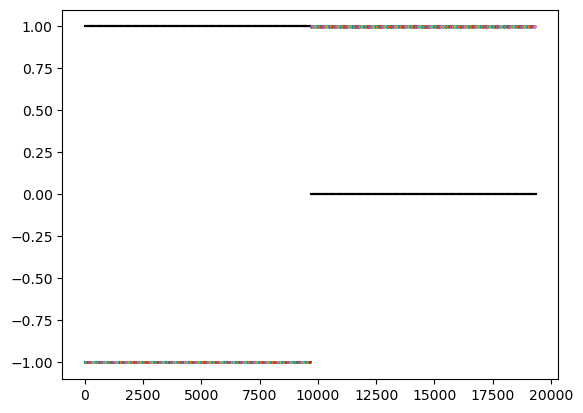

In [5]:
i = 0
for d,t in train_loader:
    for x,y in zip(d,t):
        plt.plot(np.arange(i*50,i*50+50),x[0])
        if y == 0:
            plt.plot(np.arange(i*50,i*50+50),[0]*50,c='k')
        else:
            plt.plot(np.arange(i*50,i*50+50),[1]*50,c='k')
        i += 1

In [4]:
next(iter(train_loader))

[tensor([[[4332533., 4332728., 4332809.,  ..., 4332879., 4332533., 4332659.],
          [4718678., 4718592., 4718592.,  ..., 4718592., 4718788., 4718778.],
          [3796551., 3796403., 3796602.,  ..., 3795531., 3796375., 3796698.],
          [5243068., 5243282., 5243129.,  ..., 5243108., 5243141., 5243280.]],
 
         [[4337294., 4337788., 4337755.,  ..., 4337284., 4337782., 4337853.],
          [4718719., 4719356., 4718592.,  ..., 4718797., 4718634., 4718634.],
          [3801298., 3802899., 3803785.,  ..., 3803441., 3803244., 3803498.],
          [5243161., 5243207., 5243258.,  ..., 5243283., 5243048., 5243214.]],
 
         [[4332609., 4332704., 4333107.,  ..., 4332377., 4332634., 4332759.],
          [4718592., 4718690., 4718592.,  ..., 4718592., 4718664., 4718592.],
          [3793210., 3793152., 3793234.,  ..., 3792912., 3792631., 3792882.],
          [5243136., 5243183., 5243123.,  ..., 5243222., 5243056., 5243421.]],
 
         ...,
 
         [[4337614., 4332623., 4332758.